Desbois Vinciane & Blart Louise - 2e année ENSAE

# Notebook final : La prédiction de la pente de la marge EGT 

**Rappel de la problèmatique :** Comment modéliser la vitesse d'usure d'un moteur d'avion entre deux événements de maintenance, en fonction de l'environnement dans lequel il vole ?

**Modèles utilisés :** Réseaux de Neurones Convolutifs (CNN) 

**Variable expliquée :** La pente de la marge EGT (*egt_slope*)

**Variables explicatives :** 
- Continues : l'age du moteur (*cycles_counter*), la propulsion (*Interpolate_var_mot_1*), la durée des vols (*flight_leg_hours*), les variables environnementales (*Var_env_1*, *Var_env_2*, *Var_env_3*, *Var_env_5*)
- Catégorielles : le type de moteur (*Engine_series*), la configuration de A (*Config_A*), la configuration de B (*Config_B*), variable environnementale (*Var_env_4*)



En amont de l'entrée dans les différents modèles de CNN, plusieurs prétraitements ont été effectués sur le dataframe initialement fourni par Safran. Le détail de ces prétraitements est disponible sur 
[Github](https://github.com/VincianeDesbois/Safran_moteurs)
  et est résumé ci-après :

**Prétraitement :**


Notebook Pretraitement_1_Formats_Valeurs_manquantes
- Etape 1 : Les formats 
- Etape 2 : Les valeurs manquantes - Interpolation (méthode temporelle et pad) 

Notebook Pretraitement_2_Echantillonnage_Var
- Etape 3 : Echantillonnage - intervalles de même longueur (100 vols par échantillon ) 
- Etape 4 : Les variables (ordres de grandeur similaires, One Hot Encode des catégorielles) 


A la fin de ces traitements, le dataframe est complet (aucune valeur manquante), échantillonné (une unique pente par intervalle de 100 vols) et les variables sont traitées ( de même échelle et encodées pour les catégorielles).


On testera dans ce document différents modéles de CNN pour traiter la problématique : 
- Un CNN simple
- Un CNN-LSTM 
- UN CNN multihead

In [8]:
# Importation des packages 
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statistics
from statistics import mean
from random import *

# Packages modeles
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from keras.layers.core import (Dense,Dropout, Flatten)

from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import  concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.layers import TimeDistributed, LSTM

from tensorflow.keras import models
from tensorflow.keras import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_error

# Packages hyperparametres
from hyperopt import hp # pour une première utilisation : pip install hyperopt
import kerastuner as kt # pour une première utilisation :  pip install keras-tuner
hp = kt.HyperParameters()
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from keras.models import load_model
from tensorflow.keras import metrics

In [9]:
# Fonctions utilisées tout au long du notebook : 

def split_sequences(sequences, n_steps) : 
    '''
    scinder un dataframe en échantillon de taille n_steps. 
    
    Sequences : Dataframe initial correspondant aux varaibles X et Y (Y en dernière position)
    '''
    X, y = list(), list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x, seq_y = sequences [i*n_steps :(i+1)*n_steps, :-1 ], sequences[i*n_steps ,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)    

def split_sequences_X(sequences, n_steps) : 
    '''
    Découpage d'un dataframe correspondant aux variables X en échantillons de taille n_steps
    
    séquences : Dataframe correspondant aux variables X. 
    '''
    X= list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x = sequences [i*n_steps :(i+1)*n_steps,:]
        X.append(seq_x)
    return array(X)


def Compare_pred (preds, real_values ) : 
    '''
    Fonction de visualisation des prédictions
    '''
    plt.figure(figsize=(10,5))
    plt.plot(real_values,  color='darkblue', label="Vraies valeurs ")
    plt.plot(preds, 'salmon', label = "Prédictions ")
    plt.title('Confrontation prédictions et vraies valeurs')
    legend = plt.legend()
    plt.ylim(-0.25,0.25)
    plt.show()

def Compare_density (preds, real_values ) : 
    '''
    Fonction de visualisation des densités
    '''
    plt.figure(figsize=(15,8))
    ax = sns.distplot(preds, hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 1}, color="lightcoral", label = "Prédictions ")
    sns.distplot(real_values, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, color="darkturquoise" , label="Vraies valeurs ")
    legend = plt.legend()
    plt.title('Confrontation des densités de la prédictions et des vraies valeurs')
    plt.xlim(-2,2)
    plt.show() 
    
    
def visuel_train_test ( history ) : 
    '''
    Fonction de visualisation des courbes de loss pour la base train et la validation 
    '''
    plt.plot(history.history['loss'], color='b', label="Training loss")
    plt.plot(history.history['val_loss'], color='r', label="Validation loss")
    plt.title('Training and validation loss')
    plt.ylim(0,0.1)
    legend = plt.legend()
    plt.show()
    
    
# Metriques utilisées : 
def relative_absolute_error(y_true, y_pred):
        return ( mean_absolute_error( y_true,y_pred)/ mean_absolute_error( y_true, K.mean(y_true)))
    
def root_relative_squared_error(y_true, y_pred):
        return K.sqrt ( mean_squared_error( y_true,y_pred)/ mean_squared_error( y_true, K.mean(y_true)))
    

In [10]:
# Importation du Dataframe traité
X_Y_treat = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\X_Y_treat.csv')
X_Y_treat=X_Y_treat.drop(['id_int', 'Unnamed: 0' ], axis = 1)
# On retire les valeurs extrémes de la pente de la norme EGT (retrait de 4 échantillons sur 6 600)
X_Y_treat = X_Y_treat.drop(X_Y_treat[X_Y_treat.Interpolate_egt_slope<-4].index)
X_Y_treat = X_Y_treat.drop(X_Y_treat[X_Y_treat.Interpolate_egt_slope> 8].index)
X_Y_treat

,engine_series_Engine_series_1,engine_series_Engine_series_2,engine_series_Engine_series_3,engine_series_Engine_series_4,engine_series_Engine_series_5,engine_series_Engine_series_6,engine_series_Engine_series_7,config_A_Config_A_1,config_A_Config_A_2,config_A_Config_A_3,...,Interpolate_var_env_4_2.0,Interpolate_var_env_4_3.0,cycles_counter,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5,Interpolate_egt_slope
0,1,0,0,0,0,0,0,0,1,0,...,0,0,8.230577,-0.426772,1.634167,-0.549037,-0.190762,-0.498373,-0.453776,-0.027761
1,1,0,0,0,0,0,0,0,1,0,...,0,0,8.236156,-0.215641,1.234722,-0.601578,-0.215862,-0.638738,-0.408876,-0.027761
2,1,0,0,0,0,0,0,0,1,0,...,0,0,8.220134,-0.754736,1.853611,-0.564630,-0.190762,-0.814039,1.154726,-0.027761
3,1,0,0,0,0,0,0,0,1,0,...,0,0,8.223627,-0.656084,2.323333,-0.451994,-0.215862,-0.461992,0.345676,-0.027761
4,1,0,0,0,0,0,0,0,1,0,...,0,0,8.234565,-0.272599,1.966389,-0.583961,-0.349390,0.869515,-0.855902,-0.027761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661595,1,0,0,0,0,0,0,1,0,0,...,0,0,4.304065,0.704721,0.759722,-0.483550,0.193871,0.238183,1.154726,-0.029193
661596,1,0,0,0,0,0,0,1,0,0,...,0,0,6.432940,0.806313,0.763611,-0.203205,0.197381,-0.182706,0.099146,-0.029193
661597,1,0,0,0,0,0,0,1,0,0,...,0,0,7.040536,-0.174969,0.928056,4.248051,-0.229253,-1.971483,0.802866,-0.029193
661598,1,0,0,0,0,0,0,1,0,0,...,0,0,5.874931,0.630343,1.248333,-0.389441,-0.109125,0.764293,-1.308293,-0.029193


## 1. CNN simple 

### 1.1 - Le modèle

In [341]:
# On décompose le dataframe en 6612 échantillons de 100 vols 
X, y = split_sequences(X_Y_treat.values, 100)

# Décomposition en base test et train 
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state =21)
    # random_state = 21 pour une comparaison rigoureuse des modèles : entrainés sur les mêmes échantillons train-test

In [44]:
# Les callbakcs du modèle :
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # Arret de l'entrainement en cas de non apprentissage pendant 6 périodes
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Réduction du learning rate en cas de non diminution de la val_loss 
callbacks = [earlystop, learning_rate_reduction]

In [45]:
# Modèle de CNN
model_CNN = keras.Sequential()
model_CNN.add(Conv1D(filters=32, kernel_size = 2, activation="relu", input_shape= (100,X_train.shape[2])))
model_CNN.add(Conv1D(filters=64, kernel_size = 2, activation="relu", ))
model_CNN.add(AveragePooling1D(pool_size=2))
model_CNN.add(Dropout(0.05))
model_CNN.add(Flatten())
model_CNN.add(Dense(100))
model_CNN.add(Dropout(0.25))
model_CNN.add(Dense(1, activation="linear"))

model_CNN.compile(optimizer='adam', loss="mse")

In [46]:
history_CNN= model_CNN.fit(X_train, Y_train, epochs=50, validation_split = 0.2, callbacks =callbacks )

Epoch 1/50
133/133 [==============================] - 2s 11ms/step - loss: 2.9328 - val_loss: 0.0266
Epoch 2/50
133/133 [==============================] - 1s 9ms/step - loss: 0.0498 - val_loss: 0.0238
Epoch 3/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0362 - val_loss: 0.0217
Epoch 4/50
133/133 [==============================] - 1s 11ms/step - loss: 0.0272 - val_loss: 0.0202
Epoch 5/50
133/133 [==============================] - 1s 9ms/step - loss: 0.0226 - val_loss: 0.0188
Epoch 6/50
133/133 [==============================] - 1s 9ms/step - loss: 0.0186 - val_loss: 0.0179
Epoch 7/50
133/133 [==============================] - 1s 8ms/step - loss: 0.0159 - val_loss: 0.0184
Epoch 8/50
133/133 [==============================] - 1s 9ms/step - loss: 0.0134 - val_loss: 0.0166
Epoch 9/50
133/133 [==============================] - 1s 9ms/step - loss: 0.0118 - val_loss: 0.0192
Epoch 10/50
131/133 [============================>.] - ETA: 0s - loss: 0.0108
Epoch 00010: Reduce

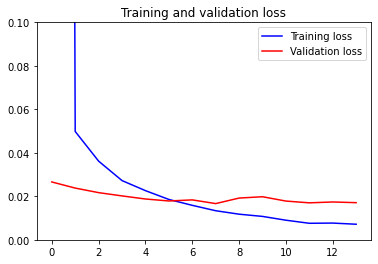

In [47]:
visuel_train_test(history_CNN)

In [48]:
# Loss du modèle
test_loss_CNN = model_CNN.evaluate(X_test, Y_test)

34/34 [==============================] - 0s 3ms/step - loss: 0.0148


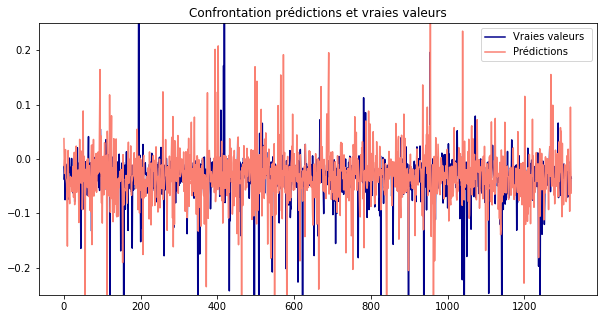

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


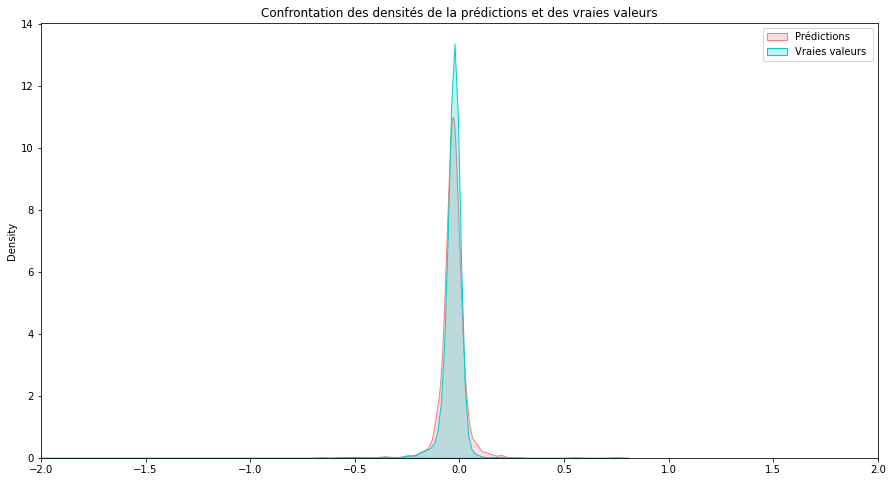

In [49]:
# Prédictions - Vissualisations
preds_CNN = model_CNN.predict(X_test)

Compare_pred (preds_CNN, Y_test )

Compare_density (preds_CNN, Y_test )

Prédictions légérement bruitées, trouvons les hyperparamètres adéquats. 

### 1.2 - Choix des hyperparamètres 

In [50]:
class Hyper_CNN (HyperModel):
    '''
    Construction du programme permettant de tester les hyperparamètres souhaités
    '''
    def __init__(self, input_shape):
        self.input_shape = (100, 27) 

    def build(self, hp):
        model = keras.Sequential()
        model.add(Conv1D(filters=hp.Choice("num_filters_1", values=[16,32], default=16),kernel_size = 2, activation="relu"))
        model.add(Conv1D(hp.Choice("num_filters_2", values=[32,64], default=32), kernel_size = 2,  activation="relu"))
        model.add(AveragePooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float("dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int("units", min_value=50, max_value=700, step=50, default=50),activation="relu"))
        model.add(Dropout(rate=hp.Float("dropout_2", min_value=0.0, max_value=0.5, default=0.25, step=0.05 )))
        model.add(Dense(1, activation="linear"))
        model.compile(optimizer='adam', loss="mse")
        return model
    
hypermodel_CNN = Hyper_CNN((100, 27))

In [51]:
# Récapitulatif des paramétres à tester
tuner_CNN= Hyperband(hypermodel_CNN, max_epochs= 40, objective = 'loss' , executions_per_trial=2, directory='hyperband', project_name='Usure_avions',overwrite = True)
tuner_CNN.search_space_summary()

Search space summary
Default search space size: 5
num_filters_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
num_filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 50, 'conditions': [], 'min_value': 50, 'max_value': 700, 'step': 50, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}


In [53]:
# Chargement des callbacks
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # Arret de l'entrainement en cas de non apprentissage pendant 6 périodes
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Réduction du learning rate en cas de non diminution de la val_loss 
callbacks = [earlystop, learning_rate_reduction]

In [54]:
# /!\ Cellule longue - 40 minutes /!\ 
# Recherhe des hyperparamètres 
tuner_CNN.search(X_train, Y_train, epochs = 20, validation_split=0.2, callbacks = callbacks)

Trial 91 Complete [00h 00m 44s]
loss: 0.005167318042367697

Best loss So Far: 0.005091905361041427
Total elapsed time: 00h 35m 46s
INFO:tensorflow:Oracle triggered exit


In [175]:
# Récapitulatif des recherchers et selection des hyperparamètres 
tuner_CNN.results_summary()

Results summary
Results in hyperband\Usure_avions
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
num_filters_1: 16
num_filters_2: 32
dropout_1: 0.0
units: 350
dropout_2: 0.15000000000000002
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0012964203488081694
Trial summary
Hyperparameters:
num_filters_1: 16
num_filters_2: 32
dropout_1: 0.15000000000000002
units: 250
dropout_2: 0.05
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0014602272713091224
Trial summary
Hyperparameters:
num_filters_1: 16
num_filters_2: 64
dropout_1: 0.0
units: 250
dropout_2: 0.4
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0021694123279303312
Trial summary
Hyperparameters:
num_filters_1: 16
num_filters_2: 32
dropout_1: 0.15000000000000002
units: 150
dropout_2: 0.1
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: b5767bbc387e69

In [55]:
# Récupération du meilleur modèle 
best_model_CNN = tuner_CNN.get_best_models(num_models=1)[0]
best_model_CNN.evaluate(X_test, Y_test)

42/42 [==============================] - 0s 2ms/step - loss: 0.0084


0.008439875207841396

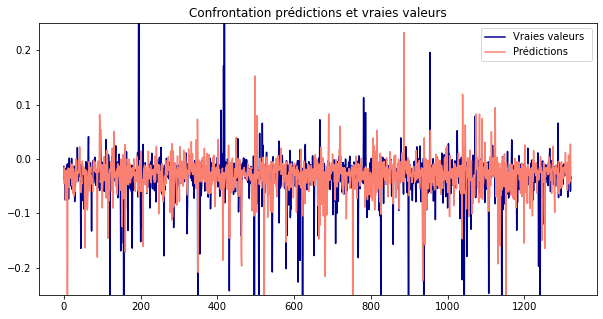

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


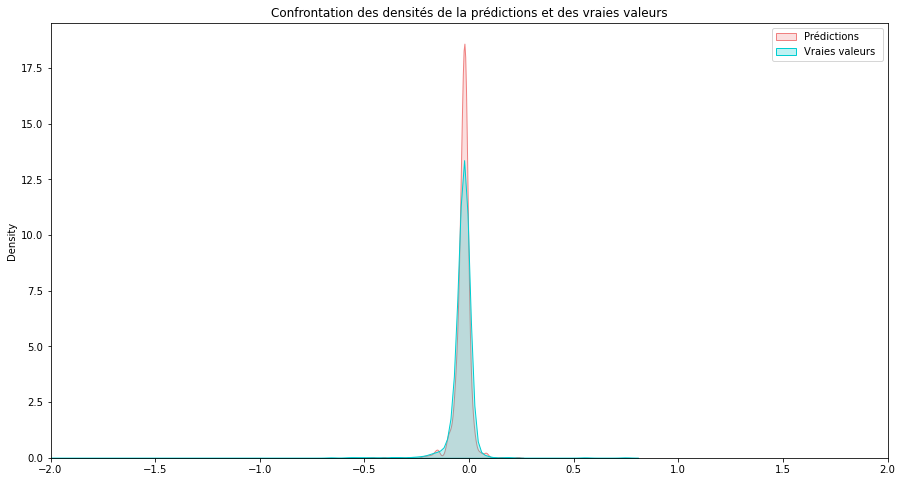

In [56]:
# Prédictions - Visualisations 
preds_best_CNN = best_model_CNN.predict(X_test)

Compare_pred (preds_best_CNN, Y_test )

Compare_density (preds_best_CNN, Y_test )

In [57]:
best_model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 99, 32)            1760      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 32)            2080      
_________________________________________________________________
average_pooling1d (AveragePo (None, 49, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               392250    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0

In [58]:
# Enregistrement du modèle :
models.save_model(best_model_CNN, 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN.h5')

## 2. CNN-LSTM

### 2.1 - Le modèle

In [340]:
# Décomposition du Dataframe 
X, y = split_sequences(X_Y_treat.values, 100 )

# On decompose  [samples, timesteps] en [samples, subsequences, timesteps, features]
X_LSTM = X.reshape((X.shape[0], 1, 100, 27))
y_LSTM = y.reshape((y.shape[0], 1, 1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X_LSTM, y_LSTM, test_size = 0.2,  random_state =21)

In [154]:
# Le modèle CNN-LSTM
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu'), input_shape=(None, 100, 27)))
model_CNN_LSTM.add(TimeDistributed(AveragePooling1D(pool_size=2)))
model_CNN_LSTM.add(TimeDistributed(Dropout(0.05)))
model_CNN_LSTM.add(TimeDistributed(Flatten()))

model_CNN_LSTM.add(LSTM(500, return_sequences=True,activation='relu'))
model_CNN_LSTM.add(LSTM(180, return_sequences = True, activation='relu'))
model_CNN_LSTM.add(LSTM(81, return_sequences=True, activation='relu'))
model_CNN_LSTM.add(TimeDistributed(Dropout(0.25)))

model_CNN_LSTM.add(Dense(1, activation="linear"), )
model_CNN_LSTM.compile(optimizer='adam', loss='mse')

In [155]:
history_CNN_LSTM = model_CNN_LSTM.fit(X_train, Y_train, epochs=50 ,validation_split = 0.2, callbacks = callbacks)

Epoch 1/50
133/133 [==============================] - 5s 35ms/step - loss: 0.0092 - val_loss: 0.0142
Epoch 2/50
133/133 [==============================] - 4s 31ms/step - loss: 0.0089 - val_loss: 0.0133
Epoch 3/50
133/133 [==============================] - 4s 31ms/step - loss: 0.0088 - val_loss: 0.0140
Epoch 4/50
131/133 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
133/133 [==============================] - 4s 31ms/step - loss: 0.0086 - val_loss: 0.0133
Epoch 5/50
133/133 [==============================] - 4s 32ms/step - loss: 0.0080 - val_loss: 0.0134
Epoch 6/50
131/133 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
133/133 [==============================] - 4s 30ms/step - loss: 0.0054 - val_loss: 0.0132
Epoch 7/50
133/133 [==============================] - 4s 29ms/step - loss: 0.0087 - val_loss: 0.0136
E

In [157]:
test_loss = model_CNN_LSTM.evaluate(X_test, Y_test)

42/42 [==============================] - 0s 7ms/step - loss: 0.0069


In [158]:
preds_CNN_LSTM = model_CNN_LSTM.predict(X_test)
preds_CNN_LSTM = preds_CNN_LSTM.reshape((1323, 1))
Y_test = Y_test.reshape((1323, 1))

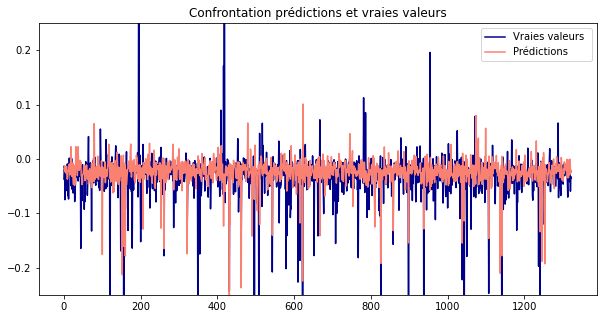

In [159]:
Compare_pred( preds_CNN_LSTM, Y_test)

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


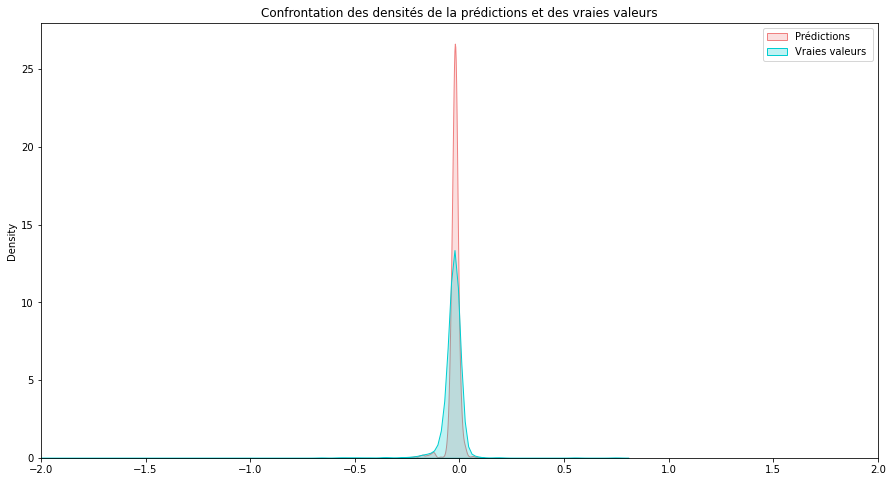

In [160]:
Compare_density(preds_CNN_LSTM, Y_test)

### 2.1 - Les hyperparamètres 

In [170]:
class CNN_LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape =(None, 100, 27)

    def build(self, hp):
        model_CNN_LSTM = keras.Sequential()
        
        model_CNN_LSTM.add(TimeDistributed(Conv1D(filters=hp.Choice("num_filters_1", values=[16,32,64], default=32),activation="relu", kernel_size=2)))
        model_CNN_LSTM.add(TimeDistributed(AveragePooling1D(pool_size=2)))
        model_CNN_LSTM.add(Dropout(rate=hp.Float("dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))
        model_CNN_LSTM.add(TimeDistributed(Flatten()))        
        model_CNN_LSTM.add(LSTM(units=hp.Int("units_1", min_value=300, max_value=800, step=10, default=500), return_sequences=True, activation='relu'))
        model_CNN_LSTM.add(LSTM(units=hp.Int("units_2", min_value=100, max_value=300, step=10, default=200), return_sequences=True, activation='relu'))
        model_CNN_LSTM.add(LSTM(units=hp.Int("units_3", min_value=1, max_value=100, step=10, default=150), return_sequences=True, activation='relu'))
        model_CNN_LSTM.add(Dropout(rate=hp.Float("dropout_2", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))

        model_CNN_LSTM.add(Dense(1, activation="linear"))

        model_CNN_LSTM.compile(optimizer='adam', loss="mse")
        return model_CNN_LSTM
    
    
hypermodel_CNN_LSTM = CNN_LSTMHyperModel(input_shape = (None, 100, 27))

In [171]:
# Récapitulatif des paramétres à tester
tuner_CNN_LSTM = Hyperband(hypermodel_CNN_LSTM, max_epochs= 40, objective = 'loss' , executions_per_trial=2, directory='hyperband', project_name='Usure_avions',overwrite = True)
tuner_CNN_LSTM.search_space_summary()

Search space summary
Default search space size: 6
num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units_1 (Int)
{'default': 500, 'conditions': [], 'min_value': 300, 'max_value': 800, 'step': 10, 'sampling': None}
units_2 (Int)
{'default': 200, 'conditions': [], 'min_value': 100, 'max_value': 300, 'step': 10, 'sampling': None}
units_3 (Int)
{'default': 150, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 10, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}


In [172]:
# Chargement des callbacks
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # Arret de l'entrainement en cas de non apprentissage pendant 6 périodes
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Réduction du learning rate en cas de non diminution de la val_loss 
callbacks = [earlystop, learning_rate_reduction]

In [173]:
# /!\ Cellule longue - 1H30  /!\ 
# Recherhe des hyperparamètres 
tuner_CNN_LSTM.search(X_train, Y_train, epochs = 20, validation_split=0.2, callbacks = callbacks)

Trial 90 Complete [00h 01m 38s]
loss: 0.007584522245451808

Best loss So Far: 0.0020997626706957817
Total elapsed time: 01h 18m 08s
INFO:tensorflow:Oracle triggered exit


In [174]:
# Récapitulatif des recherchers et selection des hyperparamètres 
tuner_CNN_LSTM.results_summary()

Results summary
Results in hyperband\Usure_avions
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
num_filters_1: 64
dropout_1: 0.25
units_1: 550
units_2: 280
units_3: 61
dropout_2: 0.15000000000000002
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 428009e3d593b1d9a024ccfcd4a9ab8b
Score: 0.0020997626706957817
Trial summary
Hyperparameters:
num_filters_1: 16
dropout_1: 0.45
units_1: 730
units_2: 130
units_3: 91
dropout_2: 0.45
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0036345775006338954
Trial summary
Hyperparameters:
num_filters_1: 16
dropout_1: 0.25
units_1: 400
units_2: 130
units_3: 51
dropout_2: 0.1
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: c5cea31ccf6cc0ee90ab94916376bab9
Score: 0.003968410426750779
Trial summary
Hyperparameters:
num_filters_1: 16
dropout_1: 0.30000000000000004
units_1: 750
units_2: 300
units_3:

In [175]:
# Récupération du meilleur modèle 
best_model_CNN_LSTM = tuner_CNN_LSTM.get_best_models(num_models=1)[0]
best_model_CNN_LSTM.evaluate(X_test, Y_test)

42/42 [==============================] - 0s 9ms/step - loss: 0.0066


0.006602176930755377

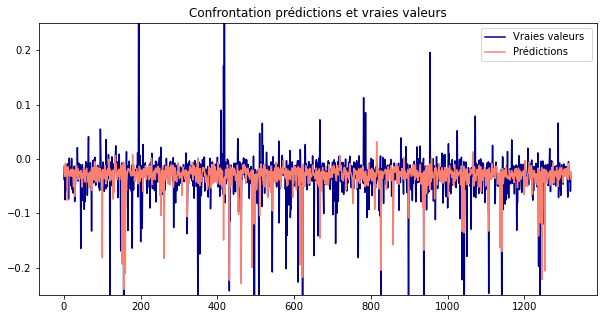

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


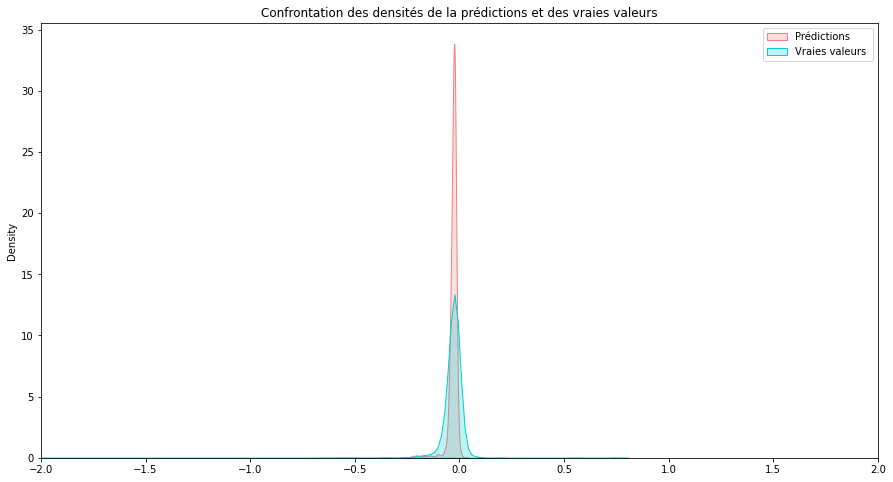

In [177]:
# Prédictions - Visualisations 
preds_best_CNN_LSTM = best_model_CNN_LSTM.predict(X_test)
preds_best_CNN_LSTM = preds_best_CNN_LSTM.reshape((1323, 1))
Y_test = Y_test.reshape((1323, 1))

Compare_pred (preds_best_CNN_LSTM, Y_test )

Compare_density (preds_best_CNN_LSTM, Y_test )

Difficile de s'éloigner de la moyenne.

In [178]:
best_model_CNN_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 99, 64)         3520      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 49, 64)         0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 3136)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 550)            8111400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 280)            930720    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 61)             8

In [179]:
# Enregistrement du modèle :
models.save_model(best_model_CNN_LSTM, 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN_LSTM.h5')

## 3. CNN Multihead 

### 3.1- Traitement des variables environnementales continues 

A partir du dataframe X_Y_treat, on souhaite décomposer les séries des variables environnementales continues en 3 séries, afin de les intégrer dans différentes branches du réseau de neurones:
- Tendance 
- Saisonnalité 
- Bruit 


Pour cela il faut trouver une période de temps ou une fréquence, sur laquelle les événements se répétent. 

In [11]:
# On décompose le dataframe complet en 6 612 échantillons de 100 vols :
dfs = np.array_split(X_Y_treat[['Interpolate_var_env_1','Interpolate_var_env_2', 'Interpolate_var_env_3', 'Interpolate_var_env_5']], X_Y_treat.shape[0]/100)

Pour exemple, on affiche le graphique représentant la série var_env_1 pour deux moteurs

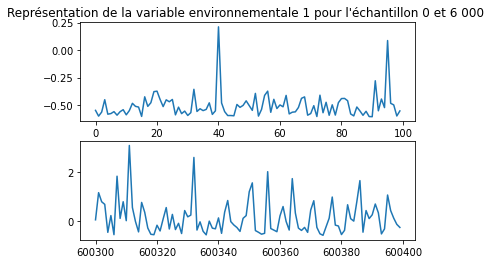

In [12]:
plt.subplot(211)
plt.title("Représentation de la variable environnementale 1 pour l'échantillon 0 et 6 000 ")
plt.plot(dfs[0]['Interpolate_var_env_1'])

plt.subplot(212)
plt.plot(dfs[6000]['Interpolate_var_env_1'])
plt.show()

Les séries sont très différentes d'un échantillon à l'autre pour une même variable environnementale. Il sera donc difficile de trouver une tendance et une saisonalité commune à tous les échantillons. En guise de simplification, on emet une hypothèse importante : 

**Hypothèse 1 :** Les moteurs ont des fréquences de répétition semblables. 

Analysons les corrélations entre les différentes variables environnementales :

<AxesSubplot:>

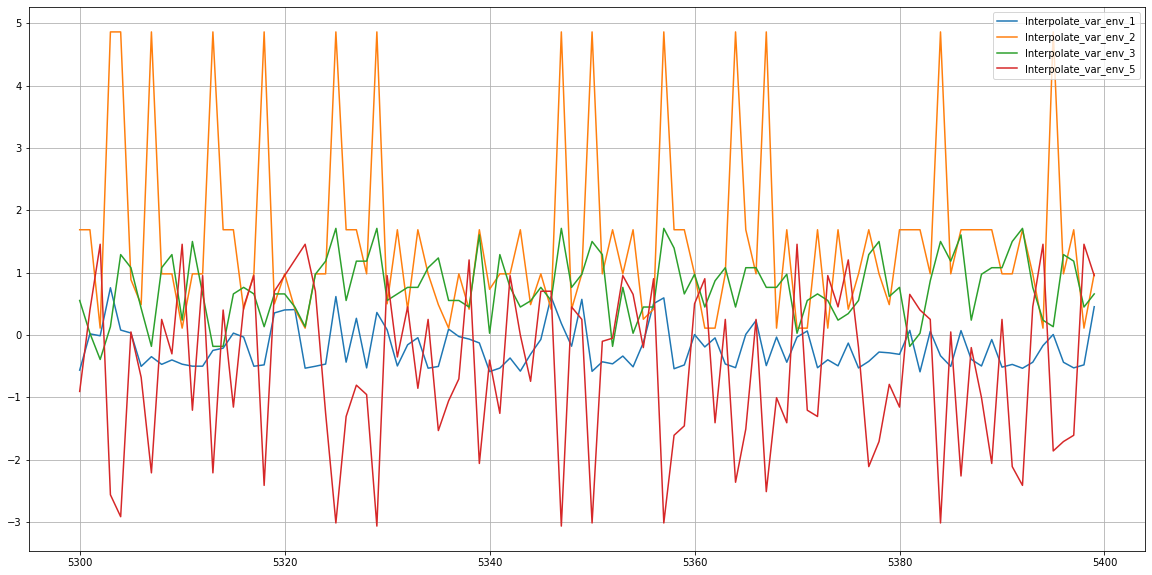

In [13]:
# Exemple pour l'échantillon 553 : 
dfs[53].plot( y=['Interpolate_var_env_1', 'Interpolate_var_env_2','Interpolate_var_env_3', 'Interpolate_var_env_5'], figsize=(20,10), grid=True)

In [14]:
X_Y_treat[['Interpolate_var_env_1','Interpolate_var_env_2','Interpolate_var_env_3','Interpolate_var_env_5']].corr()

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_5
Interpolate_var_env_1,1.000000,0.023527,0.041409,0.110937
Interpolate_var_env_2,0.023527,1.000000,0.170152,-0.163072
Interpolate_var_env_3,0.041409,0.170152,1.000000,-0.292032
Interpolate_var_env_5,0.110937,-0.163072,-0.292032,1.000000


Les variables sont corrélées, très faiblement pour certaines.

Il est donc incertain que les séries des variables environnementales aient les mêmes propriétés de saisonnalité ou de tendance. Cependant, par soucis de temps et pour simplifier nos calculs nous ne chercherons pas à différencier les propriétés des différentes variables environnementales. On emet une deuxième hypothèse : 

**Hypothèse 2** : Les temporalités des séries environnementales sont semblables. 


On peut ainsi décomposer nos séries selon une fréquence que nous initialisons à 15 : étant donné les 1400 moteurs initiaux, échantillonnés en tranches de 100 vols, un moteur est en moyenne représenté 5 fois dans les échantillons. En admettant qu'un avion répète ses trajets tous les 3 jours, on obtient une fréquence de 15.


In [15]:
def decompose_serie (serie, frequence ):
    '''
    Cette fonction permet de décomposer une série (composée de plusieurs échantillons) en fonction de la fréquence
    passée en paramètre. Elle renvoie la série décomposée en tendance, saisonnalité et bruit 
    
    Exemple :
    decompose_serie (dfs, 6 ) : décompose la série dfs, composée de 6 612 échantillons, en 3 dataframes : la tendance, 
    la saisonnalité, le bruit. 
    
    '''
    df_trend = pd.DataFrame(columns=['Var_1_trend','Var_2_trend','Var_3_trend' , 'Var_5_trend'])
    df_season = pd.DataFrame(columns=['Var_1_season','Var_2_season','Var_3_season', 'Var_5_season'])
    df_resid = pd.DataFrame(columns=['Var_1_resid','Var_2_resid','Var_3_resid' , 'Var_5_resid'])

    for i in range(len(serie)) :
        result_1 = seasonal_decompose(serie[i]['Interpolate_var_env_1'], model='additive', freq=frequence)
        result_2 = seasonal_decompose(serie[i]['Interpolate_var_env_2'], model='additive', freq=frequence)
        result_3 = seasonal_decompose(serie[i]['Interpolate_var_env_3'], model='additive', freq=frequence)
        result_5 = seasonal_decompose(serie[i]['Interpolate_var_env_5'], model='additive', freq=frequence)

        df_trend_i= pd.DataFrame({'Var_1_trend': result_1.trend ,'Var_2_trend' : result_2.trend,'Var_3_trend':result_3.trend, 'Var_5_trend':result_5.trend})
        df_trend_i= df_trend_i.fillna(df_trend_i.ffill())
        df_trend_i= df_trend_i.fillna(df_trend_i.bfill())
        df_trend = pd.concat([df_trend,df_trend_i])

        df_season_i= pd.DataFrame({'Var_1_season': result_1.seasonal ,'Var_2_season' : result_2.seasonal,'Var_3_season':result_3.seasonal, 'Var_5_season':result_5.seasonal})
        df_season = pd.concat([df_season,df_season_i])

        df_resid_i= pd.DataFrame({'Var_1_resid': result_1.resid,'Var_2_resid' : result_2.resid,'Var_3_resid':result_3.resid, 'Var_5_resid':result_5.resid})
        df_resid_i= df_resid_i.fillna(df_resid_i.ffill())
        df_resid_i= df_resid_i.fillna(df_resid_i.bfill())
        df_resid = pd.concat([df_resid,df_resid_i])

        if i == int(len(serie)/4):
            print("25% du traitement effectué")
        if i == int(len(serie)/2):
            print("50% du traitement effectué")
        if i == int(len(serie) *(3/4)):
            print("75% du traitement effectué")
        if i == int(len(serie)-1):
            print("Terminé ! ")
    return df_trend, df_season, df_resid

In [16]:
# Temps de traitement autour de 5 minutes
df_trend, df_season, df_resid = decompose_serie (dfs, 15 )

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  app.launch_new_instance()
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 


In [17]:
# On introduit le dataframe correspondant aux autres variables à prendre en compte : les caractéristiques
df_complement = X_Y_treat.drop(['Interpolate_var_env_1', 'Interpolate_var_env_2', 'Interpolate_var_env_3', 'Interpolate_var_env_5'], axis=1)

On traite nos dataframes pour qu'ils puissent entrer dans le modèle. 

On souhaite couper ce dataframe en échantillons de taille 100, où à chaque échantillon correspond une valeur de pente pour la marge EGT. 

In [18]:
df_complement

,engine_series_Engine_series_1,engine_series_Engine_series_2,engine_series_Engine_series_3,engine_series_Engine_series_4,engine_series_Engine_series_5,engine_series_Engine_series_6,engine_series_Engine_series_7,config_A_Config_A_1,config_A_Config_A_2,config_A_Config_A_3,...,config_B_Config_B_3,config_B_Config_B_4,Interpolate_var_env_4_0.0,Interpolate_var_env_4_1.0,Interpolate_var_env_4_2.0,Interpolate_var_env_4_3.0,cycles_counter,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_egt_slope
0,1,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,8.230577,-0.426772,1.634167,-0.027761
1,1,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,8.236156,-0.215641,1.234722,-0.027761
2,1,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,8.220134,-0.754736,1.853611,-0.027761
3,1,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,8.223627,-0.656084,2.323333,-0.027761
4,1,0,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,8.234565,-0.272599,1.966389,-0.027761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661595,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,4.304065,0.704721,0.759722,-0.029193
661596,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,6.432940,0.806313,0.763611,-0.029193
661597,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,7.040536,-0.174969,0.928056,-0.029193
661598,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,5.874931,0.630343,1.248333,-0.029193


In [19]:
X_complement, y = split_sequences(df_complement.values, 100)

In [20]:
df_trend

,Var_1_trend,Var_2_trend,Var_3_trend,Var_5_trend
0,-0.549615,-0.262217,-0.372647,0.282404
1,-0.549615,-0.262217,-0.372647,0.282404
2,-0.549615,-0.262217,-0.372647,0.282404
3,-0.549615,-0.262217,-0.372647,0.282404
4,-0.549615,-0.262217,-0.372647,0.282404
...,...,...,...,...
661595,0.075163,0.161777,0.062812,-0.252714
661596,0.075163,0.161777,0.062812,-0.252714
661597,0.075163,0.161777,0.062812,-0.252714
661598,0.075163,0.161777,0.062812,-0.252714


In [21]:
X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)

In [22]:
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=21)

In [23]:
# Bon format pour éviter les problèmes :
X_trend_train=np.asarray(X_trend_train).astype(np.float32)
X_season_train =np.asarray(X_season_train).astype(np.float32)
X_resid_train =np.asarray(X_resid_train).astype(np.float32)
X_trend_test=np.asarray(X_trend_test).astype(np.float32)
X_season_test =np.asarray(X_season_test).astype(np.float32)
X_resid_test=np.asarray(X_resid_test).astype(np.float32)

### 3.2- Le modèle 

In [17]:
# Metrics utilisées : 
def relative_absolute_error(y_true, y_pred):
        return ( mean_absolute_error( y_true,y_pred)/ mean_absolute_error( y_true, K.mean(y_true)))
    
def root_relative_squared_error(y_true, y_pred):
        return K.sqrt ( mean_squared_error( y_true,y_pred)/ mean_squared_error( y_true, K.mean(y_true)))
    

In [18]:
# Branche 1 : Variables caractéristiques 
visible1 = Input(shape=(100, 23))
cnn1 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible1)
cnn1 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn1)
cnn1 = AveragePooling1D(pool_size=2)(cnn1)
cnn1 = Conv1D(filters=128, kernel_size=2, activation = 'relu')(cnn1)
cnn1 = AveragePooling1D(pool_size=2)(cnn1)
cnn1 = Dropout(0.25)(cnn1)
cnn1 = Flatten()(cnn1)

# Branche 2 : Tendance Variables environnementales 
visible2 = Input(shape=(100, 4)) 
cnn2 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible2)
cnn2 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn2)
cnn2 = AveragePooling1D(pool_size=2)(cnn2)
cnn2 = Dropout(0.25)(cnn2)
cnn2 = Flatten()(cnn2)

# Branche 3 : Saisonnalité Variables environnementales 
visible3 = Input(shape=(100, 4))
cnn3 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible3)
cnn3 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn3)
cnn3 = AveragePooling1D(pool_size=2)(cnn3)
cnn3 = Dropout(0.25)(cnn3)
cnn3 = Conv1D(filters=128, kernel_size=2, activation = 'relu')(cnn3)
cnn3 = AveragePooling1D(pool_size=2)(cnn3)
cnn3 = Dropout(0.25)(cnn3)
cnn3 = Flatten()(cnn3)

# Branche 4 : Bruit Variables environnementales 
visible4 = Input(shape=(100, 4))
cnn4 = Conv1D(filters=32, kernel_size=2, activation = 'relu')(visible4)
cnn4 = Conv1D(filters=64, kernel_size=2, activation = 'relu')(cnn4)
cnn4 = AveragePooling1D(pool_size=2)(cnn4)
cnn4 = Dropout(0.25)(cnn4)
cnn4 = Flatten()(cnn4)

# Merge
merge = concatenate([cnn1, cnn2, cnn3, cnn4])
dense = Dense(300)(merge)
dense = Dense(400)(merge)

output = Dense(1, activation="linear")(dense)

model = Model(inputs=[visible1, visible2,visible3,visible4 ], outputs=output)

In [19]:
model.compile(optimizer='adam', loss='mse', metrics=[ 'mae', relative_absolute_error, root_relative_squared_error])

In [20]:
# La condition de modification de l'entrainement  
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # Arret de l'entrainement en cas de non apprentissage pendant 6 périodes
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Réduction du learning rate en cas de non diminution de la val_loss 
callbacks = [earlystop, learning_rate_reduction]

In [21]:
# Apprentissage 
history= model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=40, validation_split = 0.2, callbacks =callbacks)

Epoch 1/40
133/133 [==============================] - 4s 33ms/step - loss: 10.1774 - mae: 1.0770 - relative_absolute_error: 271.3325 - root_relative_squared_error: 271.3325 - val_loss: 0.0287 - val_mae: 0.1008 - val_relative_absolute_error: 21.1623 - val_root_relative_squared_error: 21.1623
Epoch 2/40
133/133 [==============================] - 4s 31ms/step - loss: 0.0257 - mae: 0.0981 - relative_absolute_error: 62.0880 - root_relative_squared_error: 62.0880 - val_loss: 0.0211 - val_mae: 0.0764 - val_relative_absolute_error: 16.0725 - val_root_relative_squared_error: 16.0725
Epoch 3/40
133/133 [==============================] - 4s 31ms/step - loss: 0.0192 - mae: 0.0817 - relative_absolute_error: 107.5136 - root_relative_squared_error: 107.5136 - val_loss: 0.0184 - val_mae: 0.0640 - val_relative_absolute_error: 12.4216 - val_root_relative_squared_error: 12.4216
Epoch 4/40
133/133 [==============================] - 4s 32ms/step - loss: 0.0153 - mae: 0.0706 - relative_absolute_error: 16.67

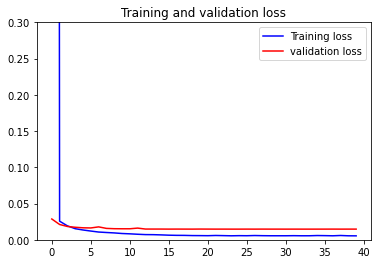

In [22]:
visuel_train_test( history )

In [23]:
# Evaluation de la loss sur la base test 
test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0411 - relative_absolute_error: 7.7921 - root_relative_squared_error: 7.7921


In [25]:
# Prédictions 
preds = model.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test])

In [26]:
mean_absolute_error(Y_test, preds)

<tf.Tensor: shape=(1323,), dtype=float32, numpy=
array([0.05306416, 0.03260371, 0.02669252, ..., 0.05021123, 0.02673867,
       0.02990857], dtype=float32)>

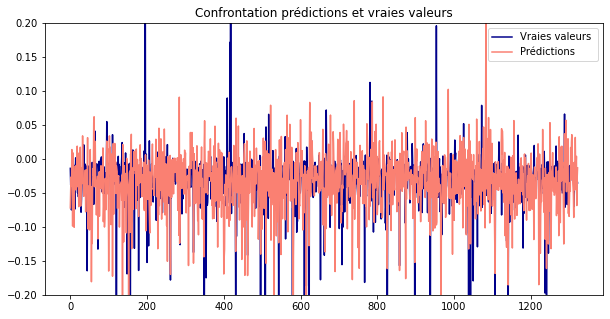

In [27]:
Compare_pred (preds, Y_test) 

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


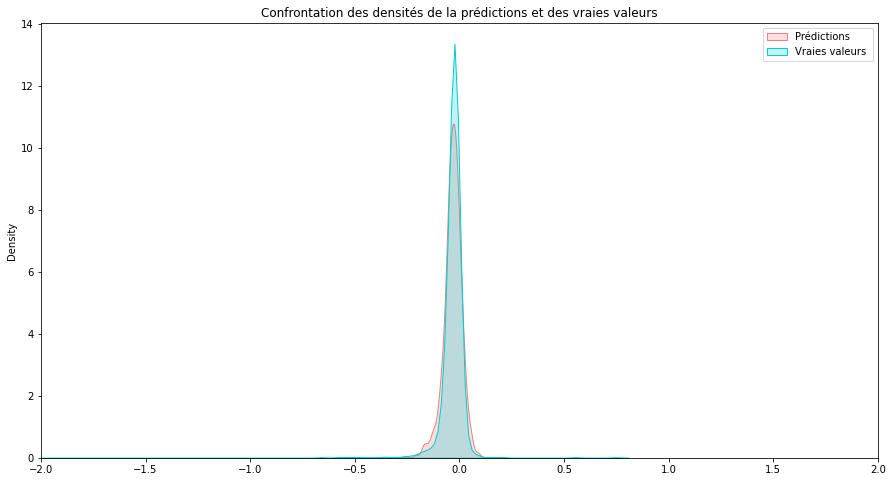

In [28]:
Compare_density (preds, Y_test ) 

### 3.3- Choix des hyperparametres 

In [29]:
keras.backend.clear_session()

In [40]:
# Création de la classe CNNHyperModel permettant de modifier les parametres souhaités

class HyperModel_CNN_multi_head (HyperModel):
    def __init__(self):
        self.input_shape_vars = (100, 23)
        self.input_shape_env = (100,4)

    def build(self, hp):

        visible1 = Input(shape=self.input_shape_vars)
        cnn1 = Conv1D(filters=hp.Choice("B1_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible1)
        cnn1 = Conv1D(filters=hp.Choice("B1_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn1)
        cnn1 = AveragePooling1D(pool_size=2)(cnn1)
        cnn1 = Conv1D(filters=128, kernel_size=2, activation = 'relu')(cnn1)
        cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cnn1 = Dropout(rate=hp.Float("B1_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05 ))(cnn1)
        cnn1 = Flatten()(cnn1)
        
        
        visible2 = Input(shape=self.input_shape_env ) 
        cnn2 = Conv1D(filters=hp.Choice("B2_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible2)
        cnn2 = Conv1D(filters=hp.Choice("B2_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn2)
        cnn2 = AveragePooling1D(pool_size=2)(cnn2)
        cnn2 = Dropout(rate=hp.Float("B2_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(cnn2)
        cnn2 = Flatten()(cnn2)
        
        
        visible3 = Input(shape=self.input_shape_env )
        cnn3 = Conv1D(filters=hp.Choice("B3_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible3)
        cnn3 = Conv1D(filters=hp.Choice("B3_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn3)
        cnn3 = AveragePooling1D(pool_size=2)(cnn3)
        cnn3 = Dropout(0.25)(cnn3)
        cnn3 = Conv1D(filters=hp.Choice("B3_num_filters_3", values=[64,128], default=128,), kernel_size=2, activation = 'relu')(cnn3)
        cnn3 = AveragePooling1D(pool_size=2)(cnn3)
        cnn3 = Dropout(rate=hp.Float("B3_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(cnn3)
        cnn3 = Flatten()(cnn3)
        
        
        visible4 = Input(shape=self.input_shape_env )
        cnn4 = Conv1D(filters=hp.Choice("B4_num_filters_1", values=[16,32], default=32,), kernel_size=2, activation = 'relu')(visible4)
        cnn4 = Conv1D(filters=hp.Choice("B4_num_filters_2", values=[32,64], default=64,), kernel_size=2, activation = 'relu')(cnn4)
        cnn4 = AveragePooling1D(pool_size=2)(cnn4)
        cnn4 = Dropout(rate=hp.Float("B4_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(cnn4)
        cnn4 = Flatten()(cnn4)
                         
                         
        merge = concatenate([cnn1, cnn2, cnn3, cnn4])
        dense = Dense(units=hp.Int("M_units_1", min_value=300, max_value=1000, step=32, default=128))(merge)
        dense = Dropout(rate=hp.Float("M_dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,))(dense)
        dense = Dense(50)(merge)
        output = Dense(1, activation="linear")(dense)
                         
                         
        model = Model(inputs=[visible1, visible2,visible3,visible4 ], outputs=output)
                         
        model.compile(optimizer=keras.optimizers.Adam(hp.Float("learning_rate",min_value=1e-4,max_value=1e-2,default=1e-3,)), loss='mse')

        return model
    
    
hypermodel_CNNM = HyperModel_CNN_multi_head()

In [41]:
tuner_CNN_M= Hyperband(hypermodel_CNNM, max_epochs= 40, objective = 'loss' , executions_per_trial=2, directory='hyperband', project_name='Usure_avions',overwrite = True)

In [42]:
# Récapitulatif des parametres à tester :
tuner_CNN_M.search_space_summary()

Search space summary
Default search space size: 16
B1_num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32], 'ordered': True}
B1_num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
B1_dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
B2_num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32], 'ordered': True}
B2_num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
B2_dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
B3_num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32], 'ordered': True}
B3_num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
B3_num_filters_3 (Choice)
{'default': 128, 'conditions': [], 'values': [64, 128], 'ordered': True}
B3_dropout_1 (Floa

In [43]:
# Les callbacks 
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # Arret de l'entrainement en cas de non apprentissage pendant 6 périodes
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Réduction du learning rate en cas de non diminution de la val_loss 
callbacks = [earlystop]

In [44]:
# /!\ Cellule longue - 45 minutes /!\
tuner_CNN_M.search([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs = 20, validation_split=0.2)

Trial 90 Complete [00h 02m 06s]
loss: 0.0042544270399957895

Best loss So Far: 0.0013555448385886848
Total elapsed time: 00h 45m 30s
INFO:tensorflow:Oracle triggered exit


In [35]:
tuner_CNN_M.results_summary()

Results summary
Results in hyperband\Usure_avions
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
B1_num_filters_1: 32
B1_num_filters_2: 32
B1_dropout_1: 0.45
B2_num_filters_1: 32
B2_num_filters_2: 32
B2_dropout_1: 0.05
B3_num_filters_1: 32
B3_num_filters_2: 64
B3_num_filters_3: 64
B3_dropout_1: 0.0
B4_num_filters_1: 16
B4_num_filters_2: 64
B4_dropout_1: 0.45
M_units_1: 908
M_dropout_1: 0.15000000000000002
learning_rate: 0.001160287323302355
tuner/epochs: 40
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.001809952431358397
Trial summary
Hyperparameters:
B1_num_filters_1: 32
B1_num_filters_2: 64
B1_dropout_1: 0.4
B2_num_filters_1: 16
B2_num_filters_2: 64
B2_dropout_1: 0.05
B3_num_filters_1: 32
B3_num_filters_2: 64
B3_num_filters_3: 128
B3_dropout_1: 0.2
B4_num_filters_1: 16
B4_num_filters_2: 64
B4_dropout_1: 0.1
M_units_1: 332
M_dropout_1: 0.1
learning_rate: 0.001277249975430383
tuner/epochs: 40
tuner/initial_epoch: 14
tuner

In [45]:
best_model_CNNM = tuner_CNN_M.get_best_models(num_models=1)[0]
best_model_CNNM.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 3ms/step - loss: 0.0081


0.00809180736541748

In [46]:
preds_best_CNN_M = best_model_CNNM.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test])

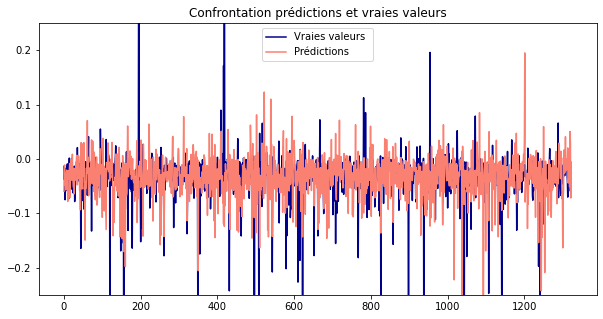

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


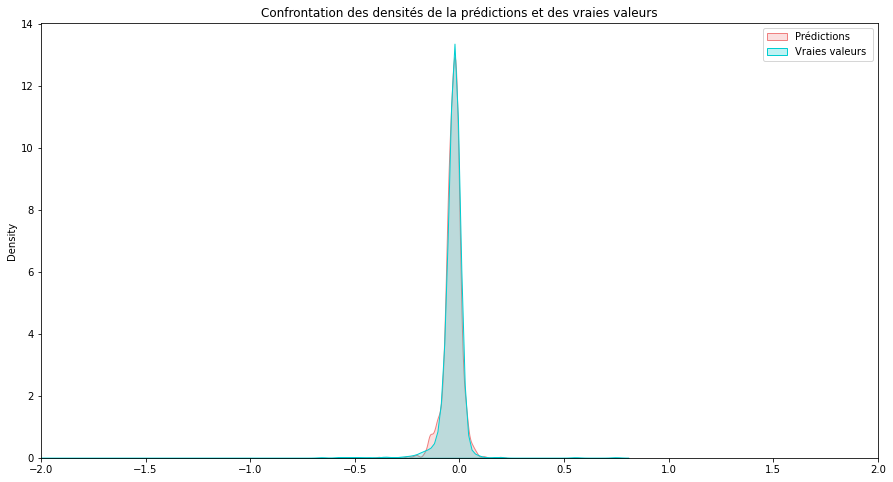

In [48]:
# Prédictions - Vissualisations
preds_best_CNN_M = best_model_CNNM.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test])

Compare_pred (preds_best_CNN_M, Y_test )

Compare_density (preds_best_CNN_M, Y_test )

In [ ]:
best_model_CNNM.summary()

In [49]:
models.save_model(best_model_CNNM, 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN_M_Freq15.h5')

### 3.4- Choix de la fréquence 

In [68]:
def choix_frequence (serie, frequences) : 
    '''
    Fonction qui teste le modèle pour différentes fréquences passées en paramètre. 
    Attention, cette fonction met un certain temps à s'effectuer : proportionnel à la taille de la série et au nombre de 
    fréquences à tester.
    Elle renvoie un dataframe comprenant les différentes fréquences associées à la loss sur la base de test. 
    '''
    df_result_freq = pd.DataFrame(columns=['Frequence','Loss'])
    for frequence in frequences : 
        print("En cours de traitement de la fréquence : ", frequence)
        df_trend, df_season, df_resid = decompose_serie (serie, frequence)
        X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)
        (X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test) = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=21)
        X_trend_train=np.asarray(X_trend_train).astype(np.float32)
        X_season_train =np.asarray(X_season_train).astype(np.float32)
        X_resid_train =np.asarray(X_resid_train).astype(np.float32)
        X_trend_test=np.asarray(X_trend_test).astype(np.float32)
        X_season_test =np.asarray(X_season_test).astype(np.float32)
        X_resid_test=np.asarray(X_resid_test).astype(np.float32)
        
        history= best_model_CNNM.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=20, validation_split = 0.2, callbacks=callbacks)
        test_loss = best_model_CNNM.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)
        
        df_result_freq_i = pd.DataFrame({'Frequence': [frequence] ,'Loss' : [test_loss]})
        df_result_freq = pd.concat([df_result_freq,df_result_freq_i])
    return df_result_freq

In [70]:
# /!\ Cellule longue - 2 heures /!\
# On teste ici pour toutes les fréquences -> Temps de traitement approximatif : 2 heures
df_result_freq = choix_frequence (dfs, list(range(1,50)))
df_result_freq

En cours de traitement de la fréquence :  1


C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  app.launch_new_instance()
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 
Epoch 1/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0155
Epoch 2/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0151
Epoch 3/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0159
Epoch 4/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0148
Epoch 5/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0141
Epoch 6/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0151
Epoch 7/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0146
Epoch 8/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0144
Epoch 9/20
133/133 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0149

,Frequence,Loss
0,1,0.008121
0,2,0.007389
0,3,0.007322
0,4,0.007330
0,5,0.007317
0,6,0.007423
0,7,0.007369
0,8,0.007252
0,9,0.007514
0,10,0.007412


In [76]:
df_result_freq[df_result_freq.Loss == df_result_freq.Loss.min()]

,Frequence,Loss
0,36,0.006826


La fréquence qui permet un meilleur apprentissag est 36. Etudions ce modèle : 

In [78]:
# On applique le modéle pour une décomposition en fréquence 36
df_trend, df_season, df_resid = decompose_serie (dfs, 36 )
df_complement = X_Y_treat.drop(['Interpolate_var_env_1', 'Interpolate_var_env_2', 'Interpolate_var_env_3', 'Interpolate_var_env_5'], axis=1)
X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=21)
# Bon format pour éviter les problèmes :
X_trend_train=np.asarray(X_trend_train).astype(np.float32)
X_season_train =np.asarray(X_season_train).astype(np.float32)
X_resid_train =np.asarray(X_resid_train).astype(np.float32)
X_trend_test=np.asarray(X_trend_test).astype(np.float32)
X_season_test =np.asarray(X_season_test).astype(np.float32)
X_resid_test=np.asarray(X_resid_test).astype(np.float32)

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  app.launch_new_instance()
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 


In [107]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6) # Arret de l'entrainement en cas de non apprentissage pendant 6 périodes
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5, min_lr=0.00001) # Réduction du learning rate en cas de non diminution de la val_loss 
callbacks = [earlystop, learning_rate_reduction]

In [108]:
history= best_model_CNNM.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=40, validation_split = 0.2, callbacks =callbacks)

Epoch 1/40
133/133 [==============================] - 1s 10ms/step - loss: 6.9852e-04 - val_loss: 0.0137
Epoch 2/40
133/133 [==============================] - 1s 9ms/step - loss: 2.8129e-04 - val_loss: 0.0137
Epoch 3/40
130/133 [============================>.] - ETA: 0s - loss: 2.9835e-04
Epoch 00003: ReduceLROnPlateau reducing learning rate to 3.6874876968795434e-05.
133/133 [==============================] - 1s 10ms/step - loss: 2.9635e-04 - val_loss: 0.0137
Epoch 4/40
133/133 [==============================] - 1s 9ms/step - loss: 4.2956e-04 - val_loss: 0.0137
Epoch 5/40
127/133 [===========================>..] - ETA: 0s - loss: 3.0001e-04
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.8437438484397717e-05.
133/133 [==============================] - 1s 9ms/step - loss: 2.9919e-04 - val_loss: 0.0137
Epoch 6/40
133/133 [==============================] - 1s 9ms/step - loss: 3.6527e-04 - val_loss: 0.0137
Epoch 7/40
129/133 [============================>.] - ETA: 0s - loss: 3.

In [109]:
best_model_CNNM.evaluate ( [X_complement_test, X_trend_test, X_season_test, X_resid_test ], Y_test )

42/42 [==============================] - 0s 2ms/step - loss: 0.0068


0.00683578522875905

In [110]:
preds_CCN_M = best_model_CNNM.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test ])

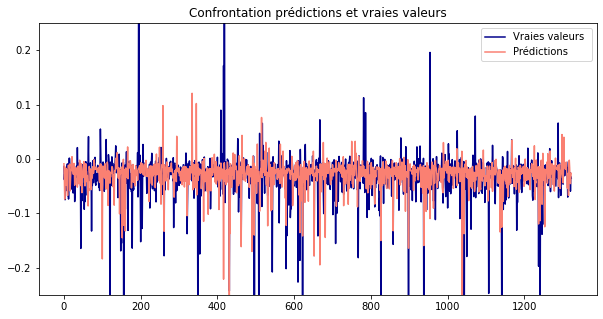

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


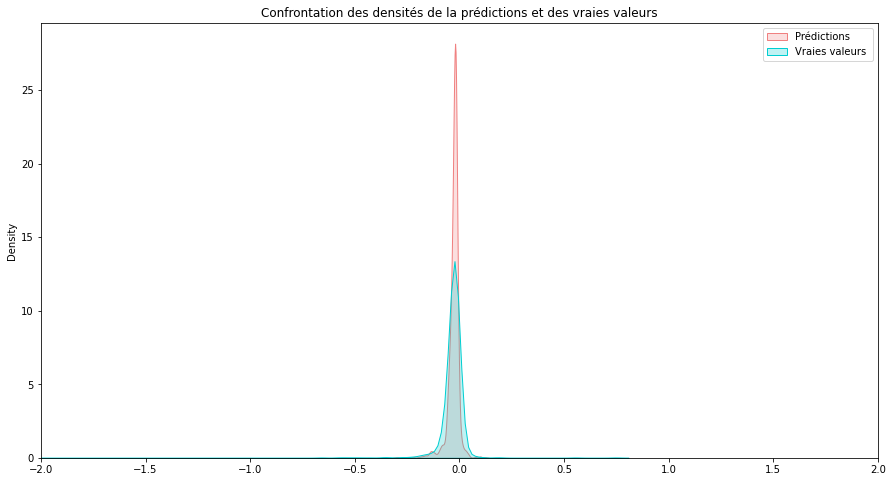

In [111]:
Compare_pred (preds_CCN_M, Y_test )

Compare_density (preds_CCN_M, Y_test )

En comparaison au modèle en fréquence 15, celui-ci se rapproche davantage de la moyenne et peine à prédire des valeurs plus importantes. Il est cependant moins bruité.

In [112]:
# Enregistrement de ce troisième modèle :
models.save_model(best_model_CNNM, 'C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN_M_Freq36.h5')

## 4 - Comparaison des modéles 

In [24]:
# Importation des métriques : 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [25]:
# Chargement des modèles :
CNN = models.load_model('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN.h5', compile = True)
CNN_LSTM =  models.load_model('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN_LSTM.h5', compile = True)
CCN_M_15 =  models.load_model('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN_M_Freq15.h5', compile = True )
CCN_M_36 =  models.load_model('C:/Users/louis/OneDrive/Documents/ENSAE/2A/Safran/CNN_M_Freq36.h5', compile = True )

In [26]:
# On récupérer les bases dans les formats adaptés à chaque modèle (On compare les résultats en restant sur le même échantillon : random_state = 21)

# Le CNN simple
X, y = split_sequences(X_Y_treat.values, 100)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state =21)

# Le CNN-LSTM
X_LSTM = X.reshape((X.shape[0], 1, 100, 27))
y_LSTM = y.reshape((y.shape[0], 1, 1, 1))
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size = 0.2,  random_state =21)

# Le CNN Multihead 
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=21)

En plus des métriques MSE et MAE déjà implémentées dans python, on ajoute la RAE, la RSE et la RSTD :

In [27]:
def relative_standard_deviation (y_true, y_pred):
       return np.std(y_pred) / np.std(y_true) 
    
def relative_absolute_error(y_true, y_pred):
    Y_mean = np.full( shape=Y_test.shape[0], fill_value=Y_test.mean(), dtype=np.float)
    return ( mean_absolute_error( y_true,y_pred)/ mean_absolute_error( y_true, Y_mean))
    
def root_relative_squared_error(y_true, y_pred):
    Y_mean = np.full( shape=Y_test.shape[0], fill_value=Y_test.mean(), dtype=np.float)
    return np.sqrt ( mean_squared_error( y_true,y_pred)/ mean_squared_error( y_true, Y_mean))

In [28]:
preds_CNN = CNN.predict(X_test)
preds_CNN_LSTM = CNN_LSTM.predict(X_test_LSTM)
preds_CNN_LSTM = preds_CNN_LSTM.reshape((1323, 1))
preds_CCN_M_15 = CCN_M_15.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test ])
preds_CCN_M_36 = CCN_M_36.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test ])

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

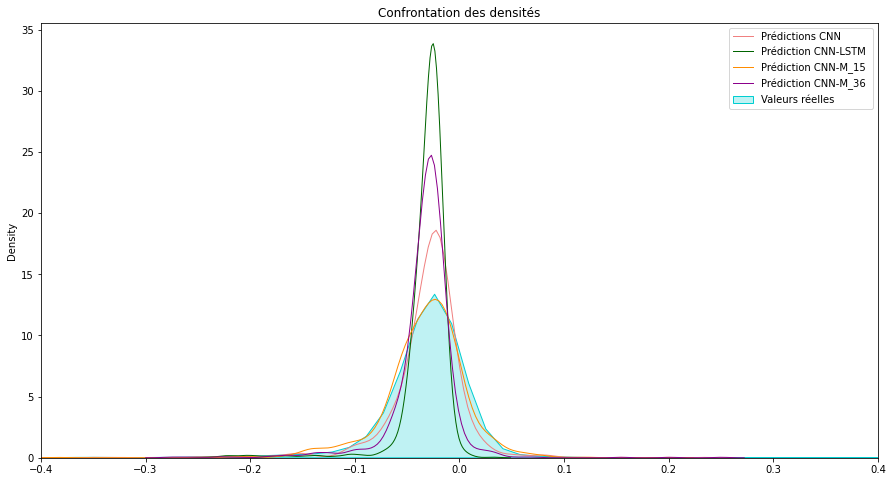

In [29]:
plt.figure(figsize=(15,8))
ax = sns.distplot(preds_CNN, hist = False, kde = True,kde_kws = {'shade': False, 'linewidth': 1}, color="lightcoral", label = "Prédictions CNN ")
sns.distplot(preds_CNN_LSTM, hist = False, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, color="darkgreen" , label="Prédiction CNN-LSTM ")
sns.distplot(preds_CCN_M_15, hist = False, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, color="darkorange" , label="Prédiction CNN-M_15 ")
sns.distplot(preds_CCN_M_36, hist = False, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, color="darkmagenta" , label="Prédiction CNN-M_36 ")

sns.distplot(Y_test, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, color="darkturquoise" , label="Valeurs réelles ")

legend = plt.legend()
plt.title('Confrontation des densités')
plt.xlim(-0.4,0.4)
plt.show() 
    

In [256]:
result_init = pd.DataFrame({'MSE': [mean_squared_error( Y_test, preds_CNN), mean_squared_error( Y_test, preds_CNN_LSTM), mean_squared_error( Y_test, preds_CCN_M_15), mean_squared_error( Y_test, preds_CCN_M_36)], 
                       'MAE': [mean_absolute_error( Y_test, preds_CNN), mean_absolute_error( Y_test, preds_CNN_LSTM), mean_absolute_error( Y_test, preds_CCN_M_15),mean_absolute_error( Y_test, preds_CCN_M_36) ], 
                       'RSE': [root_relative_squared_error( Y_test, preds_CNN), root_relative_squared_error( Y_test, preds_CNN_LSTM), root_relative_squared_error( Y_test, preds_CCN_M_15), root_relative_squared_error( Y_test, preds_CCN_M_36)] ,
                       'RAE': [relative_absolute_error( Y_test, preds_CNN), relative_absolute_error( Y_test, preds_CNN_LSTM), relative_absolute_error( Y_test, preds_CCN_M_15), relative_absolute_error( Y_test, preds_CCN_M_36)],
                        'RSTD': [relative_standard_deviation( Y_test, preds_CNN), relative_standard_deviation( Y_test, preds_CNN_LSTM), relative_standard_deviation( Y_test, preds_CCN_M_15), relative_standard_deviation( Y_test, preds_CCN_M_36)]},
                      index = ['CNN', 'CNN-LSTM', 'CNN-M_15', 'CNN-M_36'])
result_init

,MSE,MAE,RSE,RAE,RSTD
CNN,0.008440,0.035372,1.061467,1.251326,0.448334
CNN-LSTM,0.006602,0.025235,0.938819,0.892704,0.283774
CNN-M_15,0.007650,0.034330,1.010564,1.214448,0.407018
CNN-M_36,0.006836,0.028187,0.955284,0.997151,0.321365


<AxesSubplot:ylabel='RSTD'>

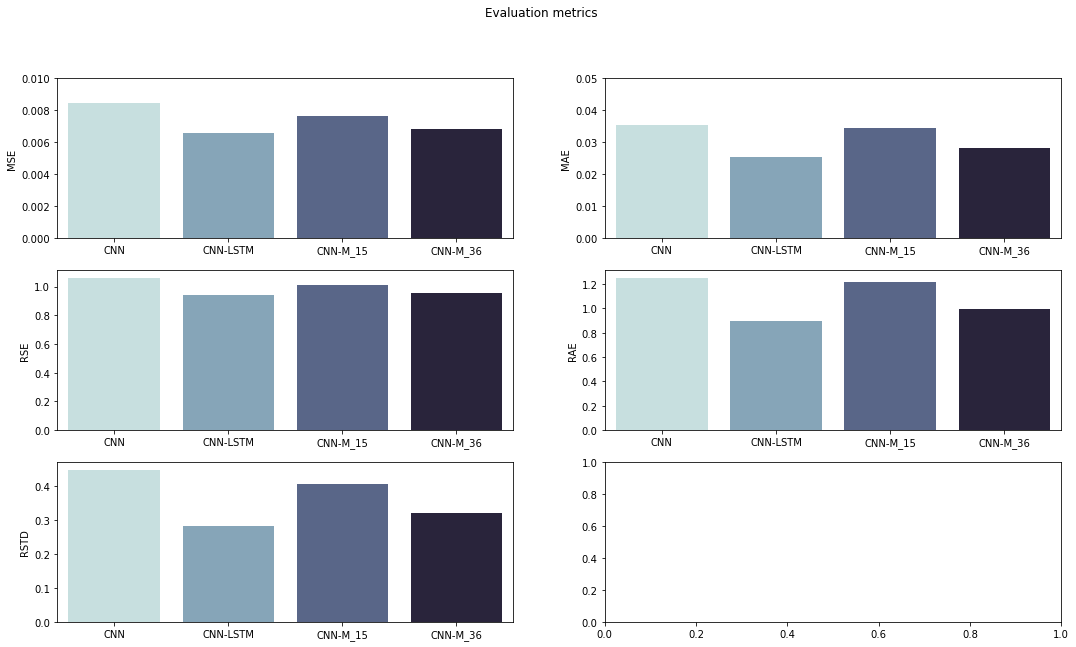

In [327]:
# Metrics :
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

fig.suptitle('Evaluation metrics ')

ax= sns.barplot(ax=axes[0, 0], data=result_init, x=result_init.index, y='MSE', palette="ch:start=.2,rot=-.3")
ax.set_ylim([0, 0.01]) 
ax1= sns.barplot(ax=axes[0, 1], data=result_init, x=result_init.index, y='MAE', palette="ch:start=.2,rot=-.3")
ax1.set_ylim([0, 0.05]) 
sns.barplot(ax=axes[1, 0], data=result_init, x=result_init.index, y='RSE', palette="ch:start=.2,rot=-.3")
sns.barplot(ax=axes[1, 1], data=result_init, x=result_init.index, y='RAE', palette="ch:start=.2,rot=-.3")
sns.barplot(ax=axes[2, 0], data=result_init, x=result_init.index, y='RSTD',  palette="ch:start=.2,rot=-.3")

On compare avec un échantillon différent (pouvant contenir des observations de train, donc ça devrait être mieux)

In [258]:
# On récupérer les bases dans les formats adaptés à chaque modèle :

# Le CNN simple
X, y = split_sequences(X_Y_treat.values, 100)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

# Le CNN-LSTM
X_LSTM = X.reshape((X.shape[0], 1, 100, 27))
y_LSTM = y.reshape((y.shape[0], 1, 1, 1))
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size = 0.2,  random_state =100)

# Le CNN Multihead 
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=100)

In [259]:
preds_CNN = CNN.predict(X_test)
preds_CNN_LSTM = CNN_LSTM.predict(X_test_LSTM)
preds_CNN_LSTM = preds_CNN_LSTM.reshape((1323, 1))
preds_CCN_M = CCN_M.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test ])

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

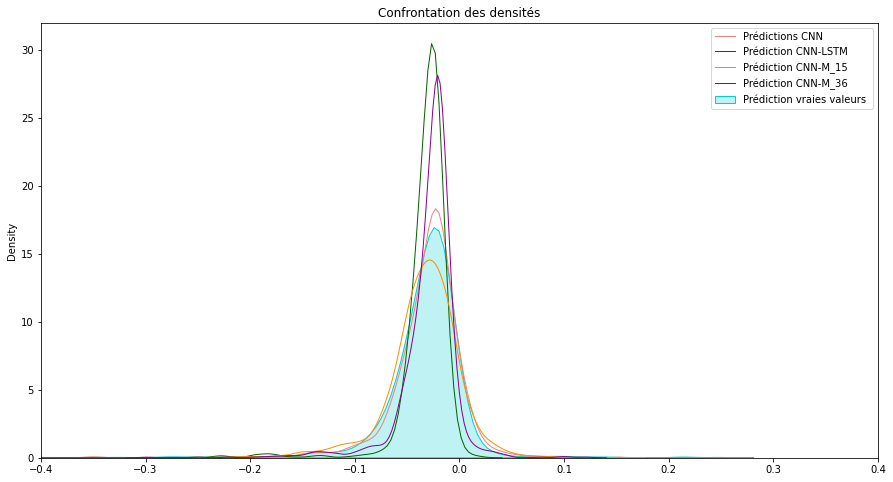

In [260]:
plt.figure(figsize=(15,8))
ax = sns.distplot(preds_CNN, hist = False, kde = True,kde_kws = {'shade': False, 'linewidth': 1}, color="lightcoral", label = "Prédictions CNN ")

sns.distplot(preds_CNN_LSTM, hist = False, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, color="darkgreen" , label="Prédiction CNN-LSTM ")
sns.distplot(preds_CCN_M_15, hist = False, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, color="darkorange" , label="Prédiction CNN-M_15 ")
sns.distplot(preds_CCN_M_36, hist = False, kde = True, kde_kws = {'shade': False, 'linewidth': 1}, color="darkmagenta" , label="Prédiction CNN-M_36 ")

sns.distplot(Y_test, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 1}, color="darkturquoise" , label="Valeurs réelles ")

legend = plt.legend()
plt.title('Confrontation des densités')
plt.xlim(-0.4,0.4)
plt.show() 
    

In [261]:
result_ech_100 = pd.DataFrame({'MSE': [mean_squared_error( Y_test, preds_CNN), mean_squared_error( Y_test, preds_CNN_LSTM), mean_squared_error( Y_test, preds_CCN_M_15), mean_squared_error( Y_test, preds_CCN_M_36)], 
                       'MAE': [mean_absolute_error( Y_test, preds_CNN), mean_absolute_error( Y_test, preds_CNN_LSTM), mean_absolute_error( Y_test, preds_CCN_M_15),mean_absolute_error( Y_test, preds_CCN_M_36) ], 
                       'RSE': [root_relative_squared_error( Y_test, preds_CNN), root_relative_squared_error( Y_test, preds_CNN_LSTM), root_relative_squared_error( Y_test, preds_CCN_M_15), root_relative_squared_error( Y_test, preds_CCN_M_36)] ,
                       'RAE': [relative_absolute_error( Y_test, preds_CNN), relative_absolute_error( Y_test, preds_CNN_LSTM), relative_absolute_error( Y_test, preds_CCN_M_15), relative_absolute_error( Y_test, preds_CCN_M_36)],
                        'RSTD': [relative_standard_deviation( Y_test, preds_CNN), relative_standard_deviation( Y_test, preds_CNN_LSTM), relative_standard_deviation( Y_test, preds_CCN_M_15), relative_standard_deviation( Y_test, preds_CCN_M_36)]},
                      index = ['CNN', 'CNN-LSTM', 'CNN-M_15', 'CNN-M_36'])
result_ech_100

,MSE,MAE,RSE,RAE,RSTD
CNN,0.002289,0.027443,1.015143,1.127157,0.739828
CNN-LSTM,0.001573,0.020510,0.841489,0.842401,0.625451
CNN-M_15,0.003531,0.036661,1.260849,1.505768,0.747482
CNN-M_36,0.003047,0.031049,1.171314,1.275288,0.590181


On obtient des résultats différents

In [244]:
def stabilite ( n ) :
        
    '''
    On teste la stabilité des modéles pour n échantillons pouvant contenir des données d'entrainement
    '''
    
    
    MSE_CNN = []
    MSE_CNN_LSTM = []
    MSE_CNN_M_15 = []
    MSE_CNN_M_36 = [ ]
    
    MAE_CNN = []
    MAE_CNN_LSTM = []
    MAE_CNN_M_15 = []
    MAE_CNN_M_36 = [ ]
    
    RSE_CNN = []
    RSE_CNN_LSTM = []
    RSE_CNN_M_15 = []
    RSE_CNN_M_36 = [ ]
    
    RAE_CNN = []
    RAE_CNN_LSTM = []
    RAE_CNN_M_15 = []
    RAE_CNN_M_36 = [ ]
    
    RSTD_CNN = []
    RSTD_CNN_LSTM = []
    RSTD_CNN_M_15 = []
    RSTD_CNN_M_36 = [ ]
    
    # On génére 50 entiers aléatoires
    l = [randint(0,1000) for i in range(n)]
    for i in l : 
        # Importation des bases de train et test 
        # Le CNN simple
        X, y = split_sequences(X_Y_treat.values, 100)
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = i)
        # Le CNN-LSTM
        X_LSTM = X.reshape((X.shape[0], 1, 100, 27))
        y_LSTM = y.reshape((y.shape[0], 1, 1, 1))
        X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size = 0.2,  random_state =i)
        # Le CNN Multihead 
        X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=i)
        
        # Les prédictions : 
        preds_CNN = CNN.predict(X_test)
        preds_CNN_LSTM = CNN_LSTM.predict(X_test_LSTM)
        preds_CNN_LSTM = preds_CNN_LSTM.reshape((1323, 1))
        preds_CCN_M = CCN_M.predict([X_complement_test, X_trend_test, X_season_test, X_resid_test ])
        
        # Metrics
        MSE_CNN.append(mean_squared_error( Y_test, preds_CNN))
        MSE_CNN_LSTM.append(mean_squared_error( Y_test, preds_CNN_LSTM))
        MSE_CNN_M_15.append(mean_squared_error( Y_test, preds_CCN_M_15)) 
        MSE_CNN_M_36.append(mean_squared_error( Y_test, preds_CCN_M_36)) 
        
        MAE_CNN.append(mean_absolute_error( Y_test, preds_CNN))
        MAE_CNN_LSTM.append(mean_absolute_error( Y_test, preds_CNN_LSTM))
        MAE_CNN_M_15.append (mean_absolute_error( Y_test, preds_CCN_M_15)) 
        MAE_CNN_M_36.append(mean_absolute_error( Y_test, preds_CCN_M_36)) 
        
        RSE_CNN.append(root_relative_squared_error( Y_test, preds_CNN))
        RSE_CNN_LSTM.append(root_relative_squared_error( Y_test, preds_CNN_LSTM))
        RSE_CNN_M_15.append(root_relative_squared_error( Y_test, preds_CCN_M_15))
        RSE_CNN_M_36.append(root_relative_squared_error( Y_test, preds_CCN_M_36))

        RAE_CNN.append(relative_absolute_error( Y_test, preds_CNN))
        RAE_CNN_LSTM.append(relative_absolute_error( Y_test, preds_CNN_LSTM))
        RAE_CNN_M_15.append(relative_absolute_error( Y_test, preds_CCN_M_15))
        RAE_CNN_M_36.append(relative_absolute_error( Y_test, preds_CCN_M_36))

        RSTD_CNN.append(relative_standard_deviation( Y_test, preds_CNN))
        RSTD_CNN_LSTM.append(relative_standard_deviation( Y_test, preds_CNN_LSTM))
        RSTD_CNN_M_15.append(relative_standard_deviation( Y_test, preds_CCN_M_15))
        RSTD_CNN_M_36.append(relative_standard_deviation( Y_test, preds_CCN_M_36))
    
    df_stabilite = pd.DataFrame({'MSE_mean': [np.mean(MSE_CNN),np.mean(MSE_CNN_LSTM),np.mean(MSE_CNN_M_15),np.mean(MSE_CNN_M_36) ],
                                 'MSE_std': [np.std(MSE_CNN),np.std(MSE_CNN_LSTM),np.std(MSE_CNN_M_15),np.std(MSE_CNN_M_36) ],
                                 'MAE_mean': [np.mean(MAE_CNN),np.mean(MAE_CNN_LSTM),np.mean(MAE_CNN_M_15),np.mean(MAE_CNN_M_36) ], 
                                 'MAE_std': [np.std(MAE_CNN),np.std(MAE_CNN_LSTM),np.std(MAE_CNN_M_15),np.std(MAE_CNN_M_36) ], 
                                 'RSE_mean': [np.mean(RSE_CNN),np.mean(RSE_CNN_LSTM),np.mean(RSE_CNN_M_15),np.mean(RSE_CNN_M_36) ],
                                 'RSE_std': [np.std(RSE_CNN),np.std(RSE_CNN_LSTM),np.std(RSE_CNN_M_15),np.std(RSE_CNN_M_36) ],
                                 'RAE_mean': [np.mean(RAE_CNN),np.mean(RAE_CNN_LSTM),np.mean(RAE_CNN_M_15),np.mean(RAE_CNN_M_36) ],
                                 'RAE_std': [np.std(RAE_CNN),np.std(RAE_CNN_LSTM),np.std(RAE_CNN_M_15),np.std(RAE_CNN_M_36) ],
                                 'RSTD_mean': [np.mean(RSTD_CNN),np.mean(RSTD_CNN_LSTM),np.mean(RSTD_CNN_M_15),np.mean(RSTD_CNN_M_36) ],
                                 'RSTD_std': [np.std(RSTD_CNN),np.std(RSTD_CNN_LSTM),np.std(RSTD_CNN_M_15),np.std(RSTD_CNN_M_36) ]},
                      index = ['CNN', 'CNN-LSTM', 'CNN-M_15', 'CNN-M_36'])
    
        
        
        
    return df_stabilite

In [248]:
stabilite(50)

,MSE_mean,MSE_std,MAE_mean,MAE_std,RSE_mean,RSE_std,RAE_mean,RAE_std,RSTD_mean,RSTD_std
CNN,0.006334,0.003151,0.030236,0.001599,0.883576,0.153184,1.086094,0.045401,0.519967,0.116547
CNN-LSTM,0.004618,0.002761,0.022589,0.001244,0.750409,0.172852,0.811539,0.038508,0.613218,0.229228
CNN-M_15,0.010513,0.006089,0.040123,0.001973,1.095844,0.054936,1.440684,0.033775,0.427698,0.133951
CNN-M_36,0.010022,0.006014,0.034043,0.001941,1.061721,0.036552,1.221699,0.020662,0.337693,0.105762
